In [ ]:
import random
import string
import numpy as np
import pandas as pd
from scipy.stats import skewnorm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def createWeeks():
    today = datetime.now()
    three_years_ago = today - relativedelta(years=3)
    days = []
    current_date = three_years_ago
    while current_date <= today:
        days.append(current_date)
        current_date += timedelta(days=1)
    weeks = []
    current_day = 0
    while current_day < len(days):
        week = days[current_day:current_day+7]
        weeks.append(week)
        current_day += 7
    return weeks

def generate_random_string(length=10):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for _ in range(length))

def generate_tweets(tweet_dates):
    tweets = []
    for date in tweet_dates:
        tweet_text = generate_random_string()
        tweets.append((date, tweet_text))
    return tweets

def tweetDatesGenOne(age):
    tweetdates=[]
    rate = age_group(age)
    weeks = createWeeks()
    for week in weeks:
        num_tweets = np.random.poisson(rate)
        tweetdates += list(np.random.choice(week, size=num_tweets, replace=True))
    return tweetdates

def age_group(x):
    if 16 <= x <= 25:
        return 8
    elif 26 <= x <= 35:
        return 6
    elif 36 <= x <= 45:
        return 4
    elif 46 <= x <= 55:
        return 3
    elif 56 <= x <= 65:
        return 2
    elif 66 <= x <= 75:
        return 1
    elif x >= 76:
        return 0
    else:
        return 0

def genAges(numberofAges):
    skewness = -5
    rand_var = skewnorm.rvs(a=skewness, loc=40, scale=10, size=numberofAges)
    return rand_var

def genTweetsAll(howmany):
    data = []
    x = genAges(howmany)
    for y in x:
        dates = tweetDatesGenOne(y)
        tweets = generate_tweets(dates)
        tweetstriples = [(y,) + tweet for tweet in tweets]
        data.append(tweetstriples)
    return data

data = genTweetsAll(100)
flat_data = [item for sublist in data for item in sublist]
df = pd.DataFrame(flat_data, columns=['Age', 'Date', 'Tweet Content'])
print(df)

             Age                       Date Tweet Content
0      42.215609 2020-07-28 08:14:23.548657    urwjkziwgs
1      42.215609 2020-07-30 08:14:23.548657    mzcmgwpnoq
2      42.215609 2020-07-26 08:14:23.548657    xmrizfneuo
3      42.215609 2020-07-26 08:14:23.548657    tlidsujlwb
4      42.215609 2020-08-01 08:14:23.548657    ddxfvkvqqa
...          ...                        ...           ...
72594  30.807257 2023-07-21 08:14:24.912715    hngwsbskbj
72595  30.807257 2023-07-23 08:14:24.912715    vpbcihtqqu
72596  30.807257 2023-07-22 08:14:24.912715    esqjziazle
72597  30.807257 2023-07-22 08:14:24.912715    fhvvamgsfn
72598  30.807257 2023-07-22 08:14:24.912715    jwqxbyqits

[72599 rows x 3 columns]


In [ ]:
# Create 'Age Group' column
df['Age Group'] = pd.cut(df['Age'], bins=np.arange(10, 85, 5), right=False)

# Create 'Week' column
df['Week'] = df['Date'].dt.isocalendar().week

# Group by 'Age Group' and 'Week', and calculate the average number of tweets per week for each age group
df_grouped = df.groupby(['Age Group', 'Week']).size().groupby('Age Group').mean().reset_index(name='Avg Tweets per Week')

df_grouped

In [ ]:
!pip install -q dash
!pip install -q jupyter-dash

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
import plotly.express as px

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id='graph'),
])

df_grouped['Age Group'] = df_grouped['Age Group'].astype(str)

@app.callback(
    Output('graph', 'figure'),
    [Input('graph', 'id')]
)
def update_graph(input_id):
    fig = px.scatter(df_grouped, x='Age Group', y='Avg Tweets per Week',
                     title='Average Number of Tweets per Week for Each Age Group')
    return fig

app.run_server(mode='inline')

In [ ]:
!pip install -q seaborn

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame for the plot
df_plot = df_grouped.copy()
df_plot['Age Group'] = df_plot['Age Group'].apply(lambda x: x.mid)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='Age Group', y='Avg Tweets per Week')
plt.title('Average Number of Tweets per Week for Each Age Group')
plt.show()

AttributeError: 'str' object has no attribute 'mid'

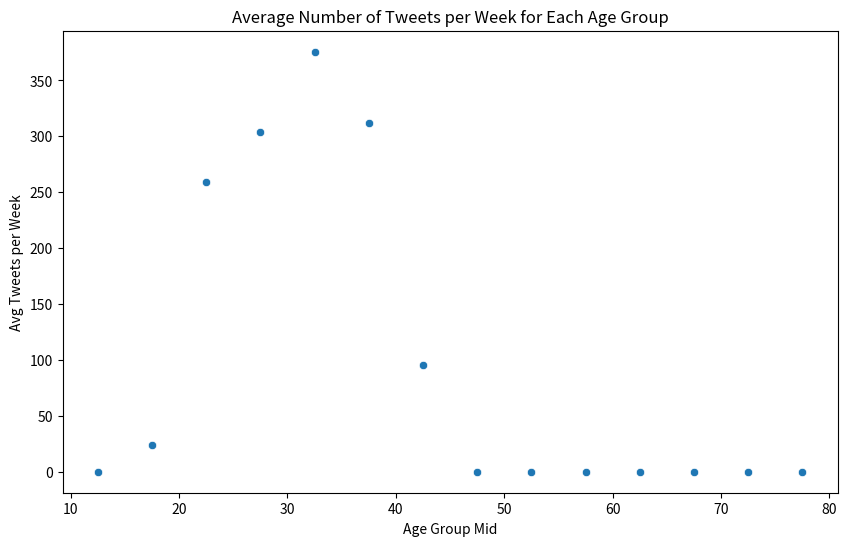

In [ ]:
# Create 'Age Group Mid' column
df_grouped['Age Group Mid'] = df_grouped['Age Group'].apply(lambda x: int(x.split(',')[0][1:]) + 2.5)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_grouped, x='Age Group Mid', y='Avg Tweets per Week')
plt.title('Average Number of Tweets per Week for Each Age Group')
plt.show()

In [ ]:
!pip install -q scikit-learn

In [ ]:
# Create a new DataFrame for the model
df_model = df.copy()
df_model['Age Group'] = pd.cut(df_model['Age'], bins=np.arange(10, 85, 5), right=False)
df_model['Week'] = df_model['Date'].dt.isocalendar().week
df_model = df_model.groupby(['Age Group', 'Week']).size().reset_index(name='Tweets per Week')

# Prepare the data for the model
X = df_model['Age Group'].apply(lambda x: x.mid).values.reshape(-1, 1)
y = df_model['Tweets per Week']

# Import the model
from sklearn.linear_model import LinearRegression

# Train the model
model = LinearRegression()
model.fit(X, y)

# Print the coefficients of the model
print('Coefficient:', model.coef_[0])
print('Intercept:', model.intercept_)

Coefficient: -3.3540203193033364
Intercept: 248.77323242794932


TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

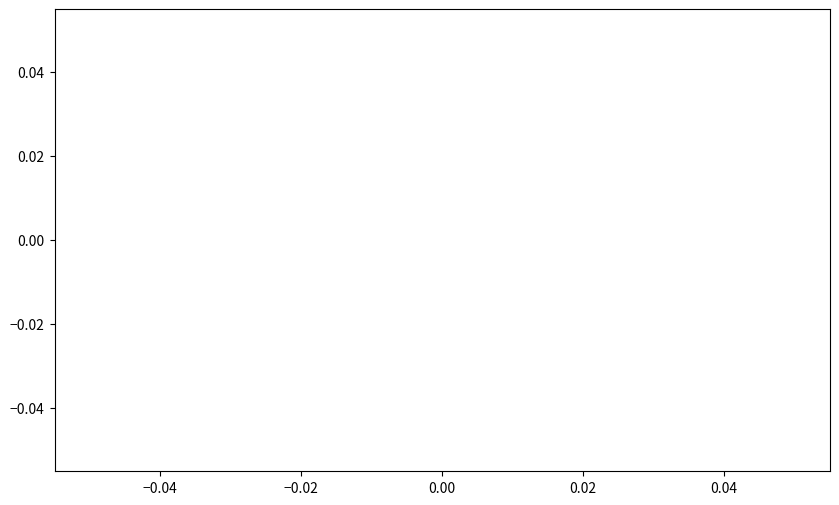

In [ ]:
# Create a range of values for 'Age' (from 10 to 80, step = 5)
ages = np.arange(10, 85, 5)

# Calculate the corresponding 'Tweets per Week' according to the model
tweets_per_week = model.coef_[0] * ages + model.intercept_

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_model, x='Age Group', y='Tweets per Week')

# Add the regression line to the plot
plt.plot(ages, tweets_per_week, color='red')

plt.title('Average Number of Tweets per Week for Each Age Group')
plt.show()

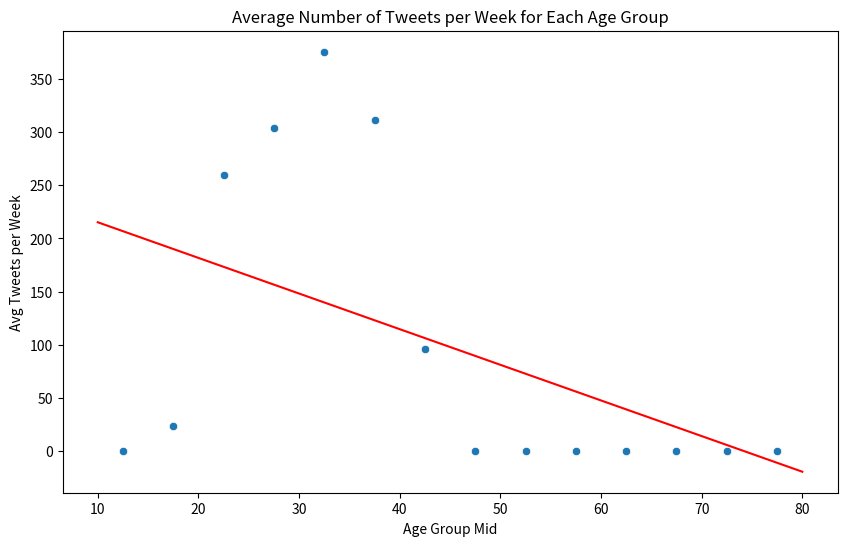

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_grouped, x='Age Group Mid', y='Avg Tweets per Week')

# Add the regression line to the plot
plt.plot(ages, tweets_per_week, color='red')

plt.title('Average Number of Tweets per Week for Each Age Group')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict the 'Tweets per Week' for the data
y_pred = model.predict(X)

# Calculate the metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

# Print the metrics
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 96.13564708190148
Mean Squared Error: 15311.81101460712
Root Mean Squared Error: 123.74090275493839
R-squared: 0.22986182231544106
